# Code cell 1:

In [7]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("Is CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 1.10.2+cu113
CUDA Version: 11.3
Is CUDA Available: True
GPU Name: GeForce GTX 1080
Using device: cuda


# Code cell 2:

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


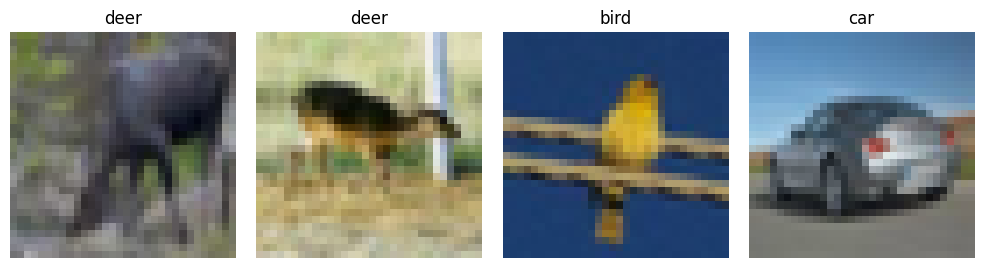

In [8]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show images
def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:4]
    labels = labels[:4]
    
    # Denormalize images
    images = images / 2 + 0.5
    
    plt.figure(figsize=(10, 10))
    for idx in range(4):
        plt.subplot(4, 4, idx+1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(classes[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")
show_images(train_loader)

# Code cell 3:

Epoch [1/10], Train Loss: 1.5111, Train Acc: 0.4621, Val Acc: 0.5523, Test Acc: 0.5519
Epoch [2/10], Train Loss: 1.2023, Train Acc: 0.5791, Val Acc: 0.5873, Test Acc: 0.5933
Epoch [3/10], Train Loss: 1.0757, Train Acc: 0.6260, Val Acc: 0.6188, Test Acc: 0.6188
Epoch [4/10], Train Loss: 0.9879, Train Acc: 0.6553, Val Acc: 0.6426, Test Acc: 0.6430
Epoch [5/10], Train Loss: 0.9300, Train Acc: 0.6806, Val Acc: 0.6532, Test Acc: 0.6498
Epoch [6/10], Train Loss: 0.8860, Train Acc: 0.6924, Val Acc: 0.6552, Test Acc: 0.6447
Epoch [7/10], Train Loss: 0.8450, Train Acc: 0.7082, Val Acc: 0.6606, Test Acc: 0.6636
Epoch [8/10], Train Loss: 0.8150, Train Acc: 0.7176, Val Acc: 0.6678, Test Acc: 0.6682
Epoch [9/10], Train Loss: 0.7853, Train Acc: 0.7283, Val Acc: 0.6682, Test Acc: 0.6682
Epoch [10/10], Train Loss: 0.7658, Train Acc: 0.7355, Val Acc: 0.6764, Test Acc: 0.6781


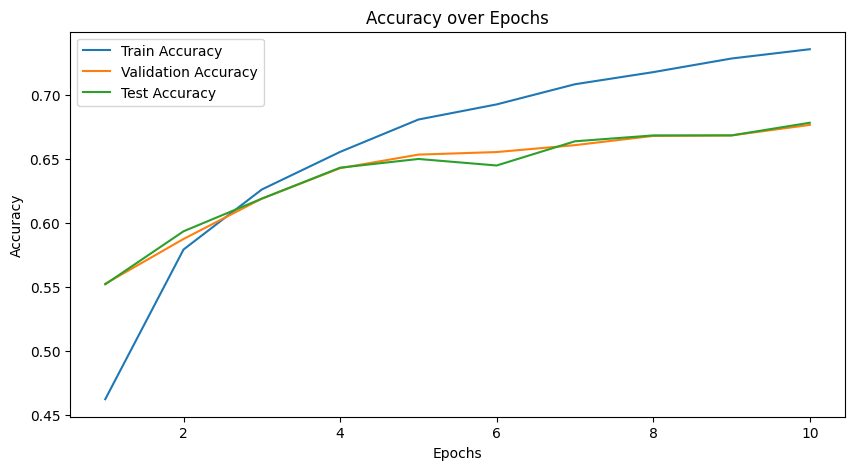

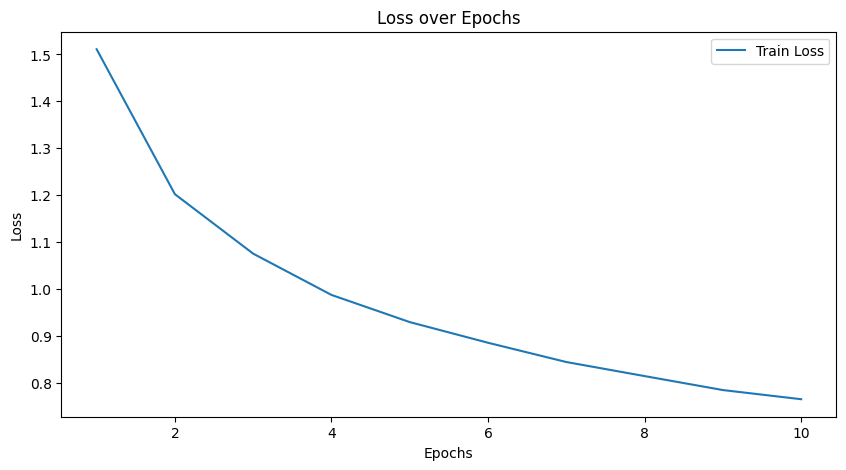

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Conv Layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Conv Layer 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling
        self.fc1 = nn.Linear(32 * 8 * 8, 10)  # Fully connected layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = self.fc1(x)  # Fully connected layer
        return x

# Instantiate the model, define loss and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_validate_test(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)

        # Testing loop
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_acc = correct_test / total_test
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accuracies, val_accuracies, test_accuracies

# Train, validate, and test the model
num_epochs = 10
train_losses, train_accuracies, val_accuracies, test_accuracies = train_validate_test(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


# Code cell 4: